## Imports

In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

In [42]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [19]:
# AE
lat_dim_ae = 12
inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(lat_dim_ae, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

start_time = time.time()
autoencoder.fit(x_train_flat, x_train_flat, epochs=10)
AE_train_time = time.time() - start_time

x_train_ae = autoencoder.predict(x_train_flat)
print(x_train_ae.shape)
x_test_ae = autoencoder.predict(x_test_flat)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0344
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0240
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0220
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0209
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0202
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0196
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0180
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0171
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0166
Epoch 10/10
1875/1875 [==============================] - 2s 904us/step
(60000, 784)
313/313 [==============================] - 0s 897us/step


In [22]:
# SVD
lat_dim_svd = 12
svd = TruncatedSVD(n_components=lat_dim_svd*lat_dim_svd)

start_time = time.time()
svd.fit(x_train_ae)
svd_train_time = time.time() - start_time

x_train_svd = svd.transform(x_train_ae)
x_test_svd = svd.transform(x_test_ae)
x_train_svd.shape

(60000, 144)

In [23]:
x_train_reduced = x_train_svd
x_test_reduced = x_test_svd

In [ ]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

## evaluation on MLPClassifier

### functions

In [5]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver='lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

In [6]:
def my_score(mlp_model1, x_test):
    y_pred = mlp_model1.predict(x_test)

    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [56]:
def performance_evaluation(x_train,x_test):
    start_time = time.time()
    mlp_model = make_mlp_model(x_train, y_train)
    print(f"Час навчання mlp - {time.time() - start_time}")
    my_score(mlp_model, x_test)

### Performance evaluation - original data

Час навчання mlp - 32.7086820602417
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.96      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



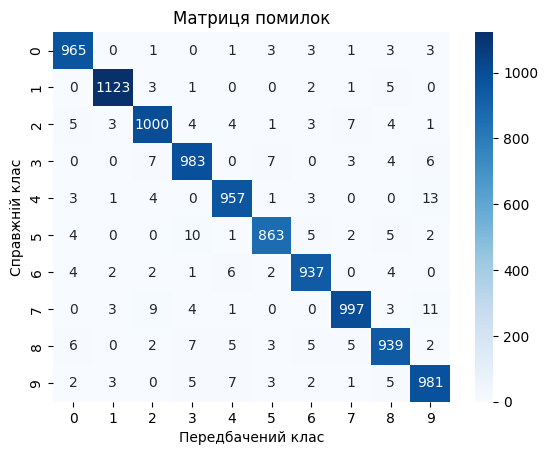

In [57]:
performance_evaluation(x_train_flat,x_test_flat)

### Performance evaluation - reduced data - only AE

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 36.81084680557251
classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.93      0.94      1010
           4       0.96      0.95      0.96       982
           5       0.93      0.94      0.94       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.93      0.93      0.93       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



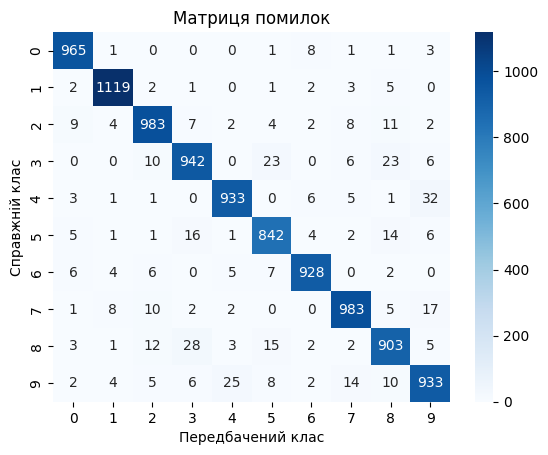

In [58]:
performance_evaluation(x_train_ae,x_test_ae)

### Performance evaluation - reduced data - only SVD

### Performance evaluation - reduced data

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 19.98948049545288
classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.93      0.94      0.94      1010
           4       0.96      0.95      0.96       982
           5       0.95      0.94      0.94       892
           6       0.97      0.96      0.97       958
           7       0.96      0.95      0.96      1028
           8       0.93      0.93      0.93       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



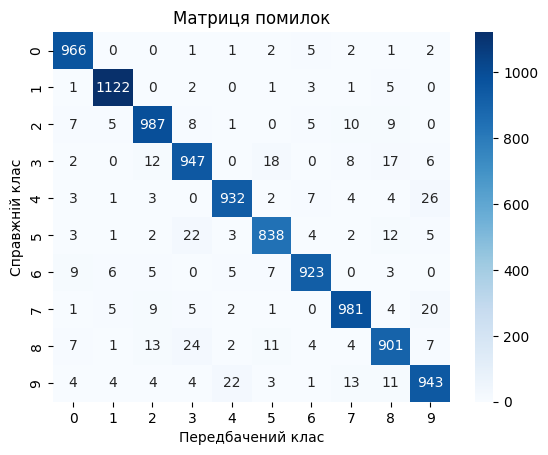

In [59]:
performance_evaluation(x_train_reduced,x_test_reduced)

# visualisation

In [43]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [44]:
X_recovered = svd.inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [45]:
x_svd_lat = x_train_svd.reshape(len(x_train_svd), lat_dim_svd, -1)
x_svd_lat.shape

(60000, 12, 12)

In [28]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

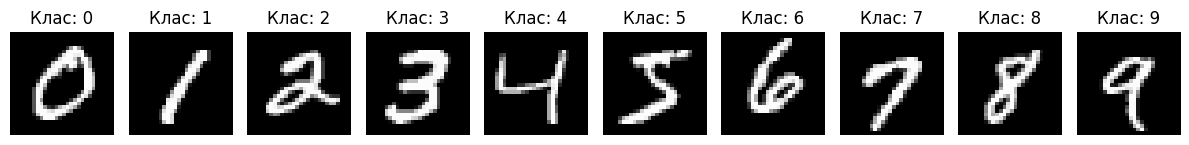

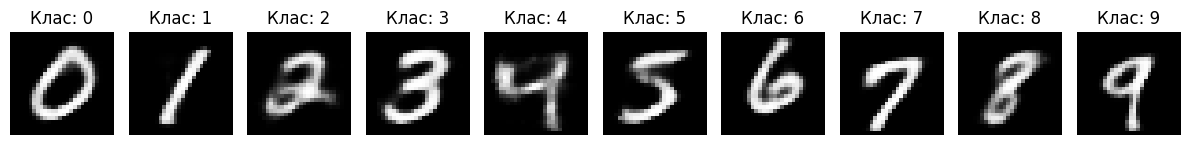

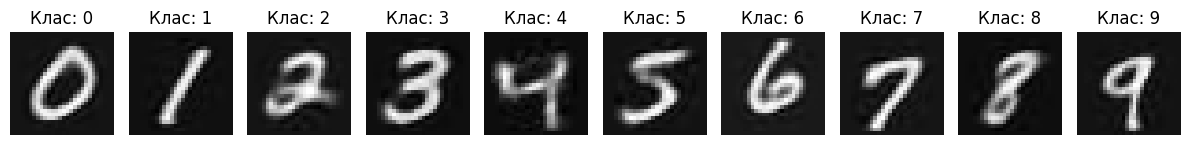

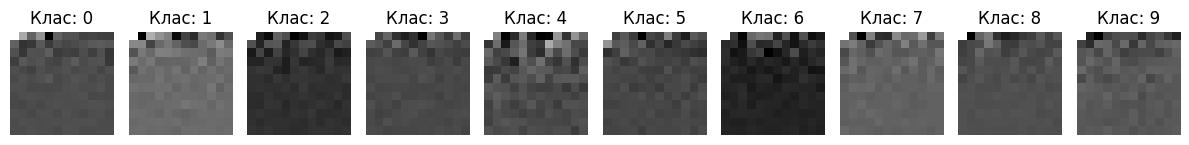

In [46]:
plot_classes(x_train,y_train)
plot_classes(x_ae,y_train)
plot_classes(x_svd,y_train) # after svd inverse
plot_classes(x_svd_lat,y_train) # clean svd

# TODO 
- read: https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset
- як впливає автоенкодер
- доп. алгоритими до пайплайну
- функція оцінки ресурсів
- дослідити для яких алгоритмів (дерева рішень, класифікація) ми отримаємо перевагу від редукції